# Introduction to Machine Learning
---
### Learning Objectives
- Data preprocessing 
    - Normalization
    - Create test and train subsets
    - Fix random number generator for reproducibility
    
- Dimensionality reduction
    - PCA
    - UMAP
 
- Supervised Learning
    - Decision trees
    - Evaluating model performance
    - Cross-validation
    
- Unsupervised Learning
    - K-means clustering
    - Quality metrics

In [1]:
# let's import the usual libraries, we will import more functions and modules as needed throughout the lesson
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The package we use for this lesson is the `scikit-learn` machine learning package. It comes with a lot of utilities to prepare our data for machine learning, as well as the code to train and evaluate models on our data.

An early example of an application of machine learning was the attempt to automate postal services to correctly read and sort every piece of mail by reading the zip code that the sender has written on the box. Throughout this lesson, we will use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) of handwritten digits, a commonly used dataset as an example in tutorials like this or for benchmarking performance of new models or algorithms. 

We use a subset of this dataset available through `scikit-learn`. This dataset contains 1797 scans of handwritten digits from 0 to 9. Each scan is an 8x8 pixel image which is flattened (i.e. `8*8=64 pixels`) to make a 1797 x 64 array. This dataset is used for machine learning experiments so the correct label of each image (i.e. row in the array) is already known and stored in the `target` array. 

Keep in mind that when you are working with real world machine learning problems, you will most likely not have the true labels for every data points and your goal will be to train models on the labeled data such that you can then make predictions about the data for which you do not have the "true labels". For example, you might train on MRI images that an expert has already gone through and labeled tissue as having cancerous growth or not. You could then use the trained model to predict whether new MRI images have cancerous growths in order to flag images needing further inspection by the doctor. 

Back to our MNIST hand-written digit classification task, let's look at the data first.

### The dataset

The `scikit-learn` package is named `sklearn` when importing in Python. It has a `datasets` module that comes with a few small standard datasets that do not require you to download any file from some external website. 

You can see the which other ones are available and what function to call to load them here: 
https://scikit-learn.org/stable/datasets/index.html#toy-datasets

In [2]:
# import the dataset
from sklearn import datasets

digits = datasets.load_digits()

print(digits.DESCR) # the .DESCR attribute will contain metadata about the dataset

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

____

The `digits` object stores the actual data (i.e. the pixel values of each hand-written image) in an attribute called `.data`

For the MNIST dataset, the first shape value will tell you how many samples you have (1797 images) and the second value will indicate the shape of the features of each sample (64 pixels). 

In [8]:
# check the shape of the array
digits.data.shape

(1797, 64)

The `digits` object also has to store the labels, typically termed targets, for each of our 1797 images in the `.target` attribute. 

The size of the `digits.target` array should be the same as the number of samples we have for our data. 

We can also see what all the possible labels are for our dataset by using `np.unique()`.

In [12]:
# digits.targets should be the same length as len(digits.data)
print(digits.target.shape)

# what are the digits we have the images of
np.unique(digits.target)

(1797,)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The images have been flattened (i.e.every row of pixels in our image were just concatenated into a long 1-D array) so if we want to look at our data, we will need to reshape them using the `arr.reshape()` function where `arr` is our numpy array.

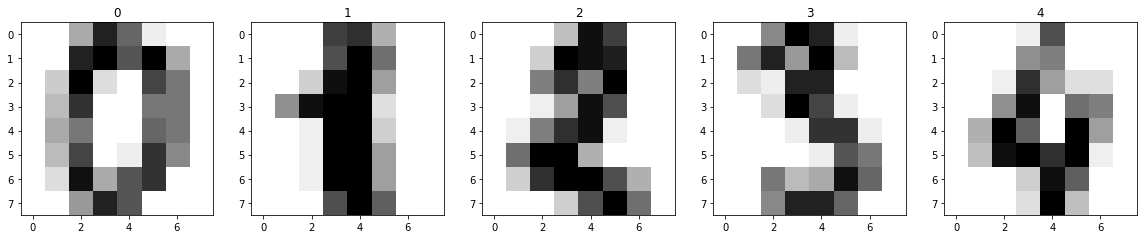

In [14]:
# visualize a few of the digit images (i.e. rows in the array)
# the first 5 images/rows:
fig, axes = plt.subplots(1,5, figsize=(20,10))
for i,ax in enumerate(axes):
    # reshape will take our 1x64 array and turn it into an 8x8 array
    image_2d = digits.data[i].reshape(8,8) 
    
    ax.imshow(image_2d, cmap='gray_r')
    ax.set_title(digits.target[i])

Note that the 8x8 (2-dimensional) version of the data is stored in `digits.images` for quick-access, so you could also do the following instead:

(1797, 8, 8)


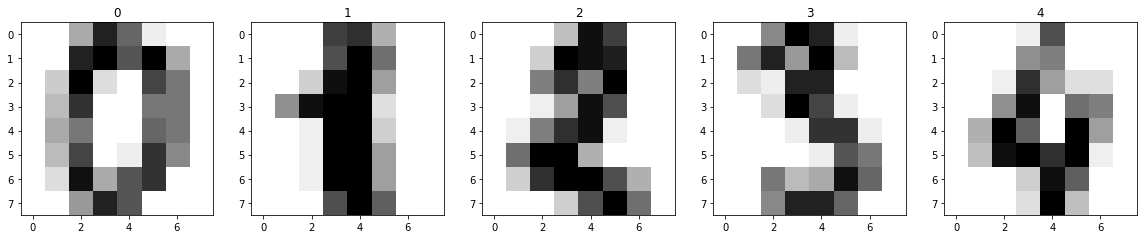

In [15]:
# check the shape (images x height x width)
print(digits.images.shape)

# plot the first five images again
fig, axes = plt.subplots(1,5, figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r') # no need to reshape
    ax.set_title(digits.target[i])

## Pre-processing our data
#### Adjust scaling of the features 

An important step in pre-processing that usually should be done on the data before applying any machine learning algorithm is standardizing the dataset, (or use any other scaling such as MinMax Scaler). Algorithms can have unexpected behaviour if you do not scale your data. 

For the specific digit dataset that we use here, all the values in the 64 columns are integer values between 0 and 16 representing the same unit (i.e. pixel intensity). So for this dataset, you wouldn't need to worry about scaling, but this may not be the case for all the datasets you work with. 

In many datasets, each column could be a feature with a completely different scaling and/or unit. For example in the `gapminder` dataset that we have been working with, one column is `population` in millions, and another is `life expectancy` in the range of human age. We have to standardize the dataset's features onto a unit scale, i.e. `mean=0` and `variance=1` (or other forms of normalizing), to warrrant optimal performance of our machine learning algorithms. The same information in each column will still be there, but it will look different to the human eye. 

If you want to read more, scikit-learn has a [section](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py) on the effects of not standardizing your data.
____

Even though our data is already in the same scale (since all values represent pixel intensity), it does not hurt to standardize the data, and it will introduce us to the steps involved in using most `scikit-learn` functions. 

In [3]:
# import the standard scaler from the preprocessing library
from sklearn.preprocessing import StandardScaler

# initialize an instance of the StandardScaler class
scaler = StandardScaler()

# fit_transform() will apply the appropriate transformation of our data into a scaled, unit invariant dataset
digits_data_scaled = scaler.fit_transform(digits.data)

# check the data is the same
digits_data_scaled.shape

(1797, 64)

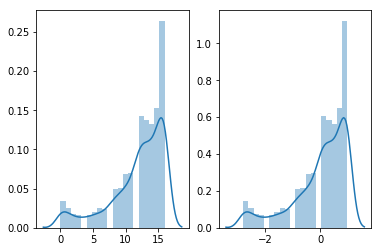

In [18]:
# and each column has the same distribution, but with moved mean
# here for example, we look at column 3

fig, (ax1,ax2) = plt.subplots(1,2)
sns.distplot(digits.data[:,3], ax=ax1)
sns.distplot(digits_data_scaled[:,3], ax=ax2);

#### Training and testing sets

As we mentioned in the previous lecture, for classification purposes, you should always test the model on a different subset of your data than the subset you trained on.

From the `scikit-learn` [documentation](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#introduction):

> Machine learning is about learning some properties of a data set and then testing those properties against another data set. A common practice in machine learning is to evaluate an algorithm by splitting a data set into two. We call one of those sets the training set, on which we learn some properties; we call the other set the testing set, on which we test the learned properties."

There is a function in `scikit-learn` to split the data for you called `train_test_split()` from the `sklearn.model_selection` library. 

`train_test_split()` will split the feature data (`digits_data_scaled`) and corresponding target labels (`digits.target`) into a training and testing set. You can also set what proportion of your dataset should be set aside for your test subset (default is 0.25, but we will set it to 0.20 to demonstrate).

Note: Look carefully at the order of the arrays output by `train_test_split`. Since we passed our features first and labels second, our data will be  returned as features (train and test) and then our targets (train and test). 

In [9]:
# import the train_test_split function
from sklearn.model_selection import train_test_split

# create our training and testing subsets
digits_train, digits_test, target_train, target_test = train_test_split(digits_data_scaled,
                                                                        digits.target, test_size=0.2)
print(digits_train.shape, digits_test.shape)

(1437, 64) (360, 64)


#### Set the random seed

We usually want to fix a random seed for consistency and reproducibility. 

In [4]:
np.random.seed(42)

Since the focus of this course is programming a workflow of machine learning algorithms, we limit the description of the concepts to short intros/reminders. 

## Machine Learning

There are two main types of learning schemes: 

- unsupervised learning
    - clustering
- supervised learning, such as 
    - Regression 
    - classiffication

The main difference between unsupervised and supervised is the explicit knowledge about the output (aka the right answer): 

- in **supervised learning** the dataset is labaled and the machine can use a direct error-based criterion to learn
- in **unsupervised learning** the machine has to identify pattern or strucutre without being provided the labels based on indirect quality measures of learning 

Note here that we can add other categories too. Briefly:

- `Semi-supervised learning` where we have some of the labels which is the case with some large datasets
- `Reinforcement learning` where the machine has to learn based on the reward that it gets from the environment for each action. 

### Dimensionality Reduction
Datasets in scientific commputation and machine learning usually have high dimensionality (e.g., images, videos, gene expression datasets, EEG). **Feature selection** and **dimensionality reduction** algorithms are used to:

1. make visual assessment of the structure of the data and 
2. improve the performance of data-driven procedures, such as those for classification and clustering.

Let's learn how to use a classic algorithm, **Principal component analysis** `PCA`, and a recently developed algorithm **Uniform Manifold Approximation and Projection**, `UMAP` using `scikit-learn`


#### PCA
By looking at the dataset we learned that each digit is represented by a 64 dimension vector, and it's this representation that is used by the machine to read and recognize the digits. We hypothesize that 64 dimensions is an overkill for this task, and that there is a smaller number of "latent" features that would be sufficient to describe the data reasonably well. 

To reduce the dimensionality of the data set, we can use PCA, which transforms the existing features into a new space removing any linear correlations that existed between the features. The transformation is defined such that the first new feature (the first principal component) is the one that explains the most of the variance in the data (the axis where the data is the most spread out). So plotting the first two principal component, spreads the data out as much as possible in two dimensions, which can make it easier to detect structure in the data.  

To use PCA we first construct a PCA object and then apply to the data using the `fit_transform` method. 

Text(0.5, 1.0, 'handwritten digits dataset projected onto principal component space')

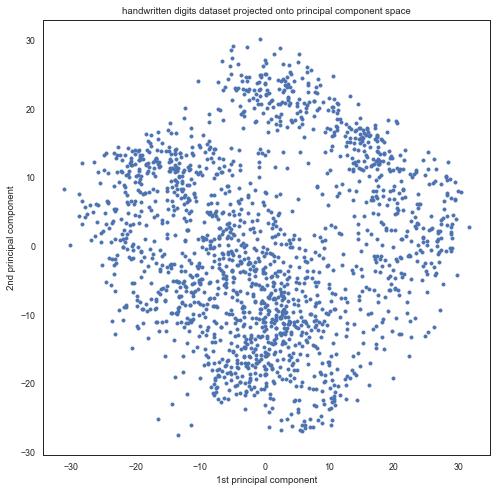

In [38]:
# import the PCA class
from sklearn.decomposition import PCA

# initialize an instance of this class to use on our data
pca = PCA() # you can also set the number of lower dimensions desired using n_components=2 or whatever number

# fit the PCA algorithm to our data, then transform our data based on the identified components
digits_pca = pca.fit_transform(digits.data)

fig, ax = plt.subplots(1,figsize=(8,8))
sns.set(context="paper", style="white")

# we want to plot the first two principal components
plt.scatter(digits_pca[:,0],digits_pca[:,1], s=10);
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
plt.title("handwritten digits dataset projected onto principal component space")

Each dot is one observation/row in our data. But without knowing the labels, which is the case in most real life problems, this plot would not be super helpful. It is unclear if there are separate clusters for each of our digits. 

In this case, we actually know the labels for each datapoint so we can color our points based on their digit label. 

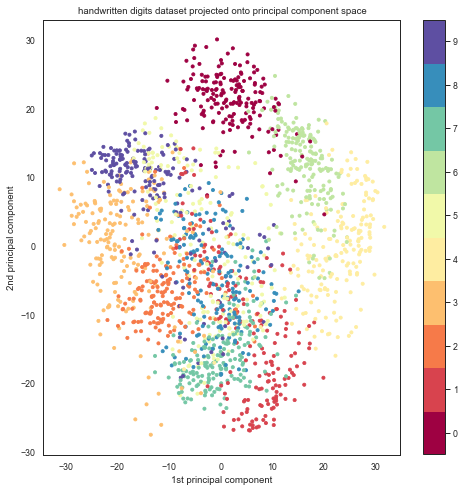

In [39]:
# import the PCA class
from sklearn.decomposition import PCA

# initialize an instance of this class to use on our data
pca = PCA() # you can also set the number of lower dimensions desired using n_components=2 or whatever number

# fit the PCA algorithm to our data, then transform our data based on the identified components
digits_pca = pca.fit_transform(digits.data)

# since we already know the target labels, we can color each dot
color = digits.target.astype(int)

fig, ax = plt.subplots(1,figsize=(8,8))
sns.set(context="paper", style="white")

# we want to plot the first two principal components
plt.scatter(digits_pca[:,0],digits_pca[:,1], c=color, cmap="Spectral", s=10);
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
plt.title("handwritten digits dataset projected onto principal component space")

# plot a colorbar to identify each color corresponds to which number
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(color)

We can see that using the first two PCs of our data does result in *some* clustering of datapoints that belong to same label, but the clusters are not very distinct. 

**A note about visualization and the number of components:**

We usually do not want to/cannot visualize more than 3 components (for publications, even 2 is preferred). You may often see plots of the first two principal components (in order of components that explain the most of the variance in our data, to those that explain the least). However, it is also likely that you may need more than 2-3 components to best represent the data for downstream machine learning. 

**In general use of dimensionality reduction techniques, we have to use a criteria that tells us how many dimensions are sufficient before we lose too much information about the data structure.**

When using PCA, we can compute the explained variance by each PC (principal component), and then use a threshold of acceptance.

For example, choose the number of components where 90% of the variance (i.e. information) in the data can be cumulatively explained. 

Alternatively, there is the **elbow-method** where you define the "elbow" or the curve or the number of PCs where the explained variance drops most significantly, and beings to decrease linearly. 

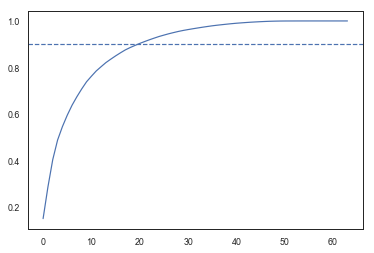

In [35]:
# get the explained variance from our pca 
explained_var = pca.explained_variance_ratio_

# compute the cumulative variance for visualization 
cumexplained_var = np.cumsum(explained_var)

# plot
plt.plot(cumexplained_var)

# draw a line at 90% of the cumulative variance
plt.axhline(y=0.9, linestyle='--');

From this plot, we can say that from the 64 original dimensions, we can safely reduce the data to 20 without losing much information, and thus, without impacting the results of any machine learning algorithms. This is using a 90% threshold for the cumulative explained variance. 

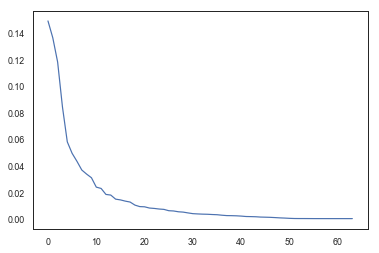

In [37]:
# using the elbow method, we plot the explained variances of the PCs in descending order (largest to smallest)
plt.plot(explained_var)


If we were using the elbow method, the elbow also appears to occur around 20 PCs, matching the result of using 90% cumulative explained variance. 

This may not be dramatic for this dataset, but it is essential for big data applications where computing resources are limited. If you would like to understand more about the linear algebra underlying the PCA algorithm, feel free to read this guide that includes more intuitive interactive visualtizations and links to more resources such as [here]( https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c).


Let's try a more advanced dimensionality reduction technique, that is especially gaining popularity in biological research such as gene expression analysis.

### UMAP

UMAP is a non-linear dimension reduction algorithm derived from topological data analysis techniques. The algorithm first constructs a fuzzy representation of the distances between the data points (observations) in the original full dimensional space, and then it optimizes a low dimensional representation that as closely as possible follows the representation in the original space.

> **We will not use this in the final assignment, so this is optional, but is a very commonly used technique in many biomedical applications of machine learning so we are including it to demonstrate the utility of the tool**
If you would like to run this code, you will need to install `UMAP` first by running  
`conda install -c conda-forge umap-learn` on your Anaconda portal. 

In the simplest form, using UMAP has two tasks similar to PCA: 
- first to instantiate the UMAP class, 
- then train that object (fit) 
- use the fitted model to transform the data. 

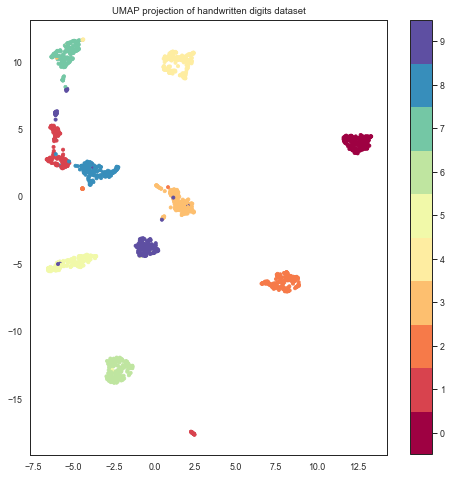

In [6]:
import umap

reducer = umap.UMAP();
embedding = reducer.fit_transform(digits.data)


fig, ax = plt.subplots(figsize=(8,8))
color = digits.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=10)
plt.title("UMAP projection of handwritten digits dataset")

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))

We observe that the UMAP projection gives bettter distinction between the different digit clusters. The figure also shows that, for example, 0 and 1  are two very distinct digits based on how far apart they are from each other, or 1 and 7 and 8 are closeby, which we know some people write these numbers very similarly to each other. 

Of course, depending of the nature of the data, there are several hyper-parameters in UMAP you may want to set: `n_neighbors` (balances the size of the local vs global strucutre), `min_dist` (minimum allowed distance between points), `n_components` (how many lower dimensions you desire), `metric` (the distance metric: e.g. Euclidean).

One important parameter to set if you want your results to be reproducible is to set the random number generator. If you haven't set it already in your notebook, you can set in in UMAP by `random_state` parameter, for example: `reducer = umap.UMAP(random_state=42)`.

We encourage you to refer to [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/#)  paper to learn more deeply how it works. 

## Supervised learning: Decision Trees


Decision Trees is a supervised learning algorithm. It can be used both for classification and regression. The algorithm predicts the target variable by learning simple `if-then-else` decision rules inferred from the data features (the columns in our dataset). 
The target/predicted variable can be either:

- a class (i.e. a discrete value) &rarr; Decision Tree Classifier
- a continuous value &rarr; Decision Tree Regressor 

The metric that define the decision rule can be `Gini impurity` or `entropy`. 

The classification tree can be imported from the `tree` library as `DecisionTreeClassifier` and the regression tree can be called as `DecisionTreeRegressor`. The instantiating, training and prediction functions of the models are similar to what we've already seen from `scikit-learn` methods, but now instead of `fit_transform()` we have `fit` and `predict` methods.  

Note: This algorithm is non-parametric and doesn't need the data to be normalised (e.g. standardized). 

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
# Decision Tree classification
classifier = DecisionTreeClassifier() # create an instance of the model
classifier.fit(digits_train, target_train) # fit (i.e. train) the model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

The `model.score()` method compares the predicted labels of the model to the actual targets passed. Here we see that the classifier scores 100% (the value is from 0 to 1.0) on the training set, but as we have mentioned earlier, testing on the same data the model already trained on is not representative of the performance of the model. Scoring the model on the test set reveals that it can accurately classify ~84% of the test set.

In [44]:
# score on the training set
classifier.score(digits_train, target_train)

1.0

In [45]:
# score on the testing set
classifier.score(digits_test, target_test)

0.8444444444444444

We can also use the trained model to output the predicted labels on the test set we created earlier. 

We can do this using the `.predict(X)` where `X` is whatever our test set feature array is and store these in a variable called `target_predicted`.

In [46]:
target_predicted = classifier.predict(digits_test)

Note: The **Random Forests** algorithm is an ensemble approach to decision trees in which the algorithm creates decision trees on randomly selected data samples, get predictions from each tree and selects the best solution by means of voting.

### Classification perfomance assessment
There are many metrics developed to assess the performance of classification algorithms. As an introduction we review some basic metrics. 

#### Calssification accuracy

The `classification_report` in `scikit-learn` shows the main classification metrics such as precision, accuracy, recall and f-1 score.

- **Accuracy** is the fraction of the correct predictions
- **Precision** or specificity is the ratio of true positive predictions to the total predicted positive predictions
- **Recall** or sensitivity is the ratio of true positives to the all the observations in the actual class (true positivies + false negatives)
- **f1-score** is a weighted average of precision and recall. 

You may have already noticed that these metrics are for binary classficiations. The extended format of such metrics treat the multiclass problems (such as the handwritten digits with 10 classes) as a collection of binary classes, averaging the binary metric calculations to get a measure across the set of classes. Parameters such as `macro` or `weighted` identify whether a simple mean or a weighted mean is used. 

In [15]:
from sklearn import metrics

In [17]:
# prediction report comparing our predicted targets to the actual targets in the test set
print(metrics.classification_report(target_test,target_predicted))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.89      0.78      0.83        41
           2       0.79      0.84      0.82        37
           3       0.88      0.90      0.89        41
           4       0.78      0.82      0.80        34
           5       0.83      0.85      0.84        40
           6       0.87      0.93      0.90        29
           7       0.85      0.83      0.84        35
           8       0.80      0.76      0.78        37
           9       0.79      0.79      0.79        34

    accuracy                           0.84       360
   macro avg       0.85      0.85      0.85       360
weighted avg       0.85      0.84      0.84       360



Here we see that the accuracy was actually ~84%. The per class precision gives us an idea of which digits were harder to classify (e.g. 78% for `4` vs 97% for `0`). 

Why do you think fours are harder to recognize than zeros? Think about the different ways people can draw a four versus a zero.

#### Confusion Matrix

Confusion matrix is a tool to visualize the performance of the classification by showing the correct and wrong predicted labels for each class. 
In a confusion matrix each row corresponds to a class based on the known labels, and the value in each cell `c_ij` is the number of observations actually in class `i`, but predicted to be in class `j`.


In [18]:
# confusion matrix
cm = metrics.confusion_matrix(target_test, target_predicted)
cm 

array([[31,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  1,  2,  1,  2,  0,  2,  1],
       [ 0,  1, 31,  0,  1,  1,  0,  0,  2,  1],
       [ 0,  1,  0, 37,  0,  0,  0,  0,  0,  3],
       [ 0,  0,  0,  0, 28,  1,  0,  4,  0,  1],
       [ 0,  0,  1,  0,  1, 34,  1,  1,  1,  1],
       [ 0,  1,  1,  0,  0,  0, 27,  0,  0,  0],
       [ 0,  0,  1,  2,  0,  3,  0, 29,  0,  0],
       [ 0,  0,  5,  0,  3,  0,  1,  0, 28,  0],
       [ 1,  1,  0,  2,  0,  1,  0,  0,  2, 27]])

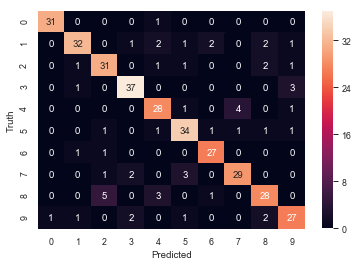

In [19]:
# better visualization of the confusion matrix
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth');

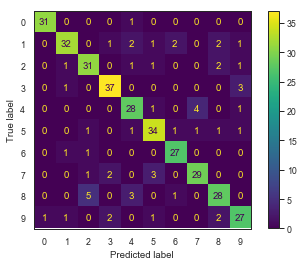

In [20]:
# note that we could directly plot the confusion matrix too
metrics.plot_confusion_matrix(classifier,digits_test,target_test);

## Unsupervised learning: Kmeans clustering
K-means is a classic clustering algorithm that takes the assumed number of clusters (k) and assigns cluster labels to each data point with the goal of minimizing the squared error between the datapoints and the centroids of the clusters. 

To emphasise: You have to give the number of clusters, k, to the algorithm, it does not do this automatically. A few methods used to find the right k to use:
- k is predefined using our knowledge about the dataset
- we can set a loop to run the algorithm with several k's, evaluate performance with some quality metrics, and choose the k with the best performance
- use the same elbow method, similar to that for PCA where we choose the value at the "elbow"/point after which the explained variance starts to decrease in a linear fashion

The strategy you use will always depend on what data you are working with. There is no magic solution that will work in all scenarios. 

Here we use our knowledge of the dataset being of 10 digits and set k = 10. This is done by setting `n_clusters` parameter in the `KMeans` class.

Like many algorithms, Kmeans is sensitive to how it the model is initialized. It is best practice to run Kmeans multiple times with different centroid seeds and choose the best output. Hence, the Kmeans algorithm within sklearn has already implemented such iterative running of Kmeans which you can define with `n_init` parameter: the number of times the Kmeans algorithm will be run (default = 10 runs).

Note: for our handwritten digits dataset, we know the output labels (i.e. the classes) but to examine the unsupervised learning algorithm k-means, we assume we don't have that knoweldege. You'll find that `data.target` is not used anywhere in the section below. 

In [30]:
from sklearn.cluster import KMeans

model_kmeans = KMeans(init='k-means++', n_clusters=10, n_init=15) ##k-means++ is a version of kmeans with better convergence
model_kmeans.fit(digits_data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Let's visualize the performance of Kmeans by coloring the datapoints in our UMAP figure by the assigned memberships by kmeans, instead of the ground truth labels 

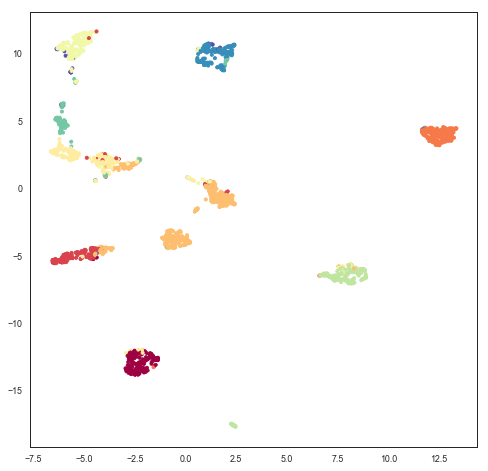

In [23]:
color = model_kmeans.labels_


fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=10)

# important note: why we didn't use the color bar here?
# the algorithm doesn't have a notion of the target digits, so the 0 to 9 that it assigns to the clusters 
# won't necessary be the digits that they represents. They are rather arbitraty labels 
# (that could as well be names like apple, orange, banana) 

We can observe that the performance is poor (i.e. the Kmeans partitions doesn't fall on the clusters of digits visualized by UMAP). It's always nice to visualize the resutls, but at the end, we have to quantify the perfromance:

### Quality metrics
There are multiple quality metrics developed to evaluate the resutls of clustering algorithms. Here we describe two.

#### Silhouette Score
The **silhouette coefficient** measures how similar a data point is to the other members of it's cluster compared to its similarity to all other data points (similarity measured by a distance metric such as Euclidean distance), i.e. if the clustering algorithm did well, members within a cluster will be very similar to each other, but not so similar to non-cluster members, resulting in a higher average silhouette score across all data points. 

The silhouette coefficient for each data point can be between 1 and -1, and the closer to 1 is an indication of better clustering. 

#### Adjusted Rand Index (ARI)
If we have the ground truth, i.e. the labels, we can validate the performance by external criteria such as ARI, which quantify the agreement between computed partitions and the ground truth partitions. 

The ARI is a `max-optimal index` meaning larger values imply a better match between the ground truth and the results of the clustering.

In [31]:
# these are available as part of the metrics library we use before
from sklearn import metrics

In [32]:
# Silhoutte 
metrics.silhouette_score(digits_data_scaled, labels=model_kmeans.labels_)

0.14603848662069588

In [34]:
# ARI
metrics.adjusted_rand_score(digits.target,model_kmeans.labels_)

0.4686324783764085

## Extra:

We noted that for big data a reduced version of the data may be more preferrable to feed into any of the algorithms.

Although 64 dimensions is not really 'big', we could apply Kmeans to the first 20 principal components of your PCA instead of the full 64 dimension array. Similarly, you could also apply Kmeans to the first two components of the UMAP embedding. 

In [57]:
#pca
digits_pca = pca.fit_transform(digits.data)
model_pca = KMeans(init='k-means++', n_clusters=10, n_init=25)
model_pca.fit(digits_pca[:,:20])

#umap
digits_umap = reducer.fit_transform(digits.data)
model_umap = KMeans(init='k-means++', n_clusters=10, n_init=25)
model_umap.fit(digits_umap[:,:2])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=25, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Here you see that using the first two components of UMAP to apply Kmeans does a very good job of representing the data in distinct clusters. Compared to using 20 PCs, each cluster has fewer points from other clusters (e.g. no blue data points in the green cluster). 

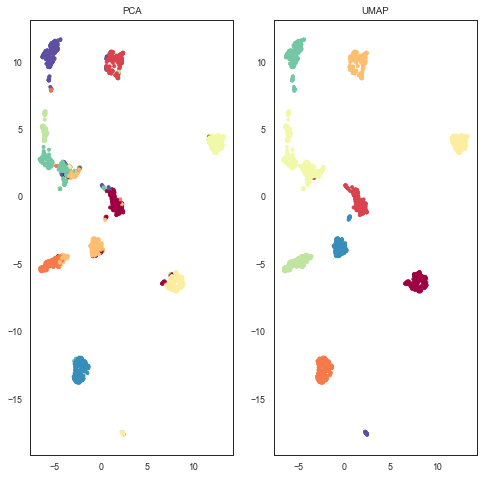

In [63]:
color_pca = model_pca.labels_
color_umap = model_umap.labels_

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))

ax1.scatter(embedding[:, 0], embedding[:, 1], c=color_pca, cmap="Spectral", s=10)
ax1.set_title("PCA");
ax2.scatter(embedding[:, 0], embedding[:, 1], c=color_umap, cmap="Spectral", s=10)
ax2.set_title("UMAP");

An important note: You should be careful in using the UMAP embeddings for clustering since these non-linear methods don't preserve the global structure of the data, for more discussion refer to the review on [UMAP instruction page](https://umap-learn.readthedocs.io/en/latest/clustering.html). 